# Hypergraphs vs. Traditional Networks

## Introduction

**Welcome!**

In this notebook, you'll explore how hypergraphs differ from traditional pairwise networks and how those differences impact how we define and measure structural properties. By the end of this tutorial, you'll be able to:

* Construct simple hypergraphs with group structure
* Measure and compare hypergraph and pairwise network properties
* Explain core differences between hypergraphs and traditional networks


The notebook is organized as follows:
* [0. Getting started](#0.-Getting-started): Instructions for installing and importing the relevant Python packages
* [1. What is a hypergraph?](#1.-What-is-a-hypergraph?): An Introduction to hypergrahs
* [2. Clique projection: From hypergraphs to pairwise networks](#2.-Clique-projection:-From-hypergraphs-to-pairwise-networks): How we relate and move between hypergraphs and traditional pairwise networks
* [3. Measuring structural properties](#3.-Measuring-structural-properties): How to measure degree distributions, homophily, and clustering in hypergraphs
* [4. Summary and exploration](#4.-Summary-and-exploration): A recap of the content of the notebook and links to additional reading
* [5. Solutions](#5.-Solutions): Solutions to the examples embedded in the notebook

## 0. Getting started

To run this notebook, you'll need to clone the following GitHub repository: [https://github.com/moritz-laber/hypergraph-information-access-inequality.git](https://github.com/moritz-laber/hypergraph-information-access-inequality.git)

Once you've cloned the repo, add this Jupyter Notebook to the main directory.

You'll need to have the following packages installed in order to import the `HyperGraph` class we use throughout the notebook:

In [1]:
import copy
import warnings
import numpy as np
from numpy.typing import ArrayLike
from scipy import optimize
import scipy.special as special
import scipy.stats as stats
from collections import defaultdict
from itertools import combinations, compress
from typing import List, Dict, Set, Union, Tuple, Callable

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


Next, import the `HyperGraph` class that we'll use:

In [2]:
from HyperGraph import HyperGraph

Now, make sure the following libraries are installed and imported:

In [3]:
import networkx as nx
import numpy as np
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt

Now you should be ready to work your way through the notebook! Enjoy!

## 1. What is a hypergraph?

**Traditional pairwise networks** (or graphs) consist of **nodes** connected by **edges**, where each edge links exactly **two** nodes. This structure is useful for modeling **dyadic interactions**, such as friendships, emails, or phone calls.

In contrast, a **hypergraph** is a generalization of a graph where edges — called **hyperedges** — can connect **any number of nodes**, not just two. Each hyperedge represents a **multi-way interaction** or **group relationship** among its member nodes.

#### Formal Definition:

A hypergraph $H=(\mathcal{V},\mathcal{E})$ is defined by:
* A set of nodes $\mathcal{V}$
* A set of hyperedges $\mathcal{E}$, where each hyperedge is a subset of $\mathcal{V}$ (i.e., $e \subseteq V$, and $∣e∣\geq 2$)

This structure allows hypergraphs to capture **higher-order interactions** that cannot be fully represented using only pairwise edges.

#### Why Use Hypergraphs?

Hypergraphs are especially useful when:
* Relationships naturally involve **groups of entities** rather than pairs.
* The **context** of a group interaction matters (e.g., being in a group chat is not equivalent to having individual conversations with each participant).
* You want to preserve **co-membership** information (e.g., all authors of a paper, all users in a shared thread, all participants in a meeting).

#### Examples:

| Scenario                       | Pairwise Network                | Hypergraph                            |
|-------------------------------|----------------------------------|----------------------------------------|
| Slack workspace               | Edges between DMs               | Each channel = one hyperedge           |
| Academic co-authorship        | Edges between coauthors         | Each paper = one hyperedge             |
| Group project participation   | Edges between teammates         | Each project team = one hyperedge      |
| Biology: protein complexes    | Edges between interacting pairs | Each complex = one hyperedge           |

### So, how can we create a hypergraph?

Let's create a hypergrpah with 6 nodes that belong to two groups. Nodes 0, 1, 2, and 3 belong to group 0, while nodes 4 and 5 belong to group 1.

We'll then create three hyperedges: {0, 1, 2}, {2, 3, 4}, and {1, 4, 5}.

In this example, everyone is joining between one and two hyperedges of size 3.

In [4]:
# Define nodes and group memberships (e.g., 0 = majority, 1 = minority)
nodes = list(range(6))
group = [0, 0, 0, 0, 1, 1]

# Define hyperedges (as sets or tuples of nodes)
edges = [
    {0, 1, 2},
    {2, 3, 4},
    {1, 4, 5}
]

# Create the hypergraph
H = HyperGraph(nodes=nodes, edges=edges, group=group)

**Exercise 1.1:** Try modifying the group memberships or edge structure. What happens if you add a 4-node edge?

## 2. Clique projection: From hypergraphs to pairwise networks

Sometimes, we want to compare a hypergraph to its pairwise counterpart.

In a **clique projection**, we convert a hypergraph into a traditional network by replacing each hyperedge with a clique, that is, by connecting every pair of nodes that appear together in the same hyperedge with a pairwise edge.

This allows us to compare a hypergraph to a more familiar graph structure, but it's important to note:
* **Structural information is lost:** We no longer know whether the original connection came from a large group or multiple small ones.
* **Edge multiplicity** is not preserved unless explicitly stored.
* **Measures like degree, homophily, or clustering** can behave very differently in the projection.

In [5]:
# Generate the clique projection
G = H.clique_projection()

In our example, this clique projection translates our size-3 hyperedges into edges between two people. For example, the hyperedge {0, 1, 2} becomes three edges: 0-1, 0-2, and 1-2.

### But how do they look?

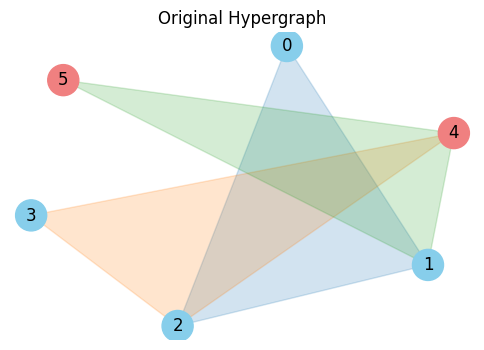

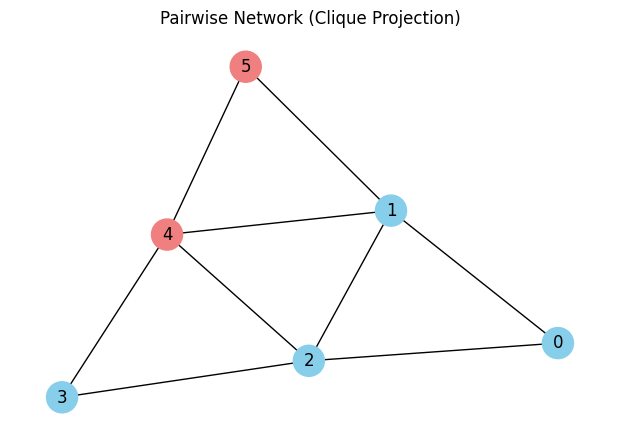

In [6]:
# Visualize the hypergraph (as nodes grouped into colored hyperedges)
def plot_hypergraph(H, title="Hypergraph"):
    plt.figure(figsize=(6, 4))
    G = nx.Graph()
    G.add_nodes_from(H.nodes)
    
    pos = nx.spring_layout(G, seed=42)  # layout for visual consistency
    
    # draw nodes
    color_map = ['skyblue' if H.group[i] == 0 else 'lightcoral' for i in H.nodes]
    nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=500)
    nx.draw_networkx_labels(G, pos)
    
    # draw hyperedges as colored convex hulls
    for i, e in enumerate(H.edges):
        pts = np.array([pos[n] for n in e])
        centroid = pts.mean(axis=0)
        for n in e:
            G.add_edge(n, n)  # self-loop placeholder to show isolated nodes
        for u, v in combinations(e, 2):
            G.add_edge(u, v)  # ghost edges just for layout

        hull_color = f"C{i % 10}"
        plt.fill(*zip(*pts), alpha=0.2, color=hull_color, label=f"Edge {i+1}")
    
    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize the clique projection
def plot_projection(H_proj, title="Clique Projection"):
    plt.figure(figsize=(6, 4))
    G_proj = nx.Graph()
    G_proj.add_nodes_from(H_proj.nodes)
    G_proj.add_edges_from(H_proj.edges)
    
    pos = nx.spring_layout(G_proj, seed=42)
    color_map = ['skyblue' if H_proj.group[i] == 0 else 'lightcoral' for i in H_proj.nodes]
    nx.draw(G_proj, pos, with_labels=True, node_color=color_map, node_size=500)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot both side by side
plot_hypergraph(H, title="Original Hypergraph")
H_proj = H.clique_projection()
plot_projection(H_proj, title="Pairwise Network (Clique Projection)")

## 3. Measuring structural properties

Let’s explore some common structural properties — and how they differ from traditional networks.

### Degree

In network analysis, the **degree** of a node is the number of edges it participates in. In other words, it can capture information such as how many people you've had a conversation with on Slack in a Slack communication network, how many people you've written papers with in an academic co-authorship network, or how many proteins co-occur with each other in a set of molecules.

* In a **pairwise network**, degree counts the number of neighbors (i.e., adjacent nodes).
* In a **hypergraph**, degree counts the number of hyperedges a node belongs to — not the number of neighbors.

This distinction is *important*: a single hyperedge might connect a node to several others, but the node's degree will only increase by 1.

#### Hypergraph

We can calculate and print the degree of each of the nodes in the hypergraph as follows:

In [7]:
# Node degree in the clique projection
for node in nodes:
    print(f"Node {node}: degree = {H.degree[node]}")

Node 0: degree = 1
Node 1: degree = 2
Node 2: degree = 2
Node 3: degree = 1
Node 4: degree = 2
Node 5: degree = 1


We can even use a histogram to plot the degree distribution.

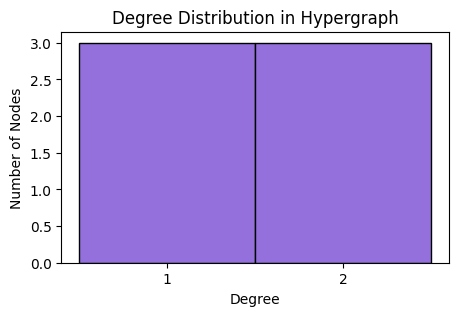

In [8]:
# Get degrees and count how many nodes have each degree
hyper_degrees = [H.degree[n] for n in nodes]

# Plot histogram of degree distribution
plt.figure(figsize=(5, 3))
plt.hist(hyper_degrees, bins=range(min(hyper_degrees), max(hyper_degrees)+2), color='mediumpurple', edgecolor='black', align='left')
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.title("Degree Distribution in Hypergraph")
plt.xticks(range(min(hyper_degrees), max(hyper_degrees)+1))
plt.show()

#### Clique projection

Like with the hypergraph, we can get the degree of each individual node with the built-in `degree()` method:

In [9]:
# Node degree in the clique projection
for node in nodes:
    print(f"Node {node}: degree = {G.degree[node]}")

Node 0: degree = 2
Node 1: degree = 4
Node 2: degree = 4
Node 3: degree = 2
Node 4: degree = 4
Node 5: degree = 2


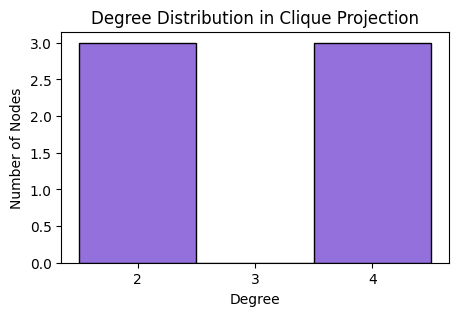

In [10]:
# Get degrees and count how many nodes have each degree
network_degrees = [G.degree[n] for n in nodes]

# Plot histogram of degree distribution
plt.figure(figsize=(5, 3))
plt.hist(network_degrees, bins=range(min(network_degrees), max(network_degrees)+2), color='mediumpurple', edgecolor='black', align='left')
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.title("Degree Distribution in Clique Projection")
plt.xticks(range(min(network_degrees), max(network_degrees)+1))
plt.show()

#### Let's compare...

In addition to the degrees of each individual node, we can calculate compare the average degree of the hypergraph to the average degree of the pairwise network:

In [11]:
# Compare average degree in hypergraph and clique projection
hypergraph_avg_deg = sum(H.degree.values()) / H.N
network_avg_deg = sum(G.degree.values()) / G.N

print(f"Hypergraph avg degree: {hypergraph_avg_deg:.2f}")
print(f"Clique projection avg degree: {network_avg_deg:.2f}")

Hypergraph avg degree: 1.50
Clique projection avg degree: 3.00


**Exercise 3.1:** Is the hypergraph average degree larger or smaller than the clique projection average degree? Why might that be?

**Exercise 3.2:** In a pairwise network, the maximum potential degree of a node is $n-1$ (i.e., if it connects to all other nodes in the network. What's the maximum potential degree of a node in a hypergraph?

### Homophily

While the avergae degree per node is different between the hypergraph and its clique projection, there doesn't appear do be a difference in average degree between groups. However, we can explore whether group membership affects which edges and hyperedges are formed using **homophily**.

On **pairwise networks**, **homophily** refers to the tendency of nodes to connect with others who are similar to them (e.g., same group). One common metric is:

$$h = \frac{\text{\# same-group edges}}{\text{total \# of edges}}$$

This is related to the idea of **dyadicity**, introduced in Park and Barabási (2007), which compares the observed count of same-group edges to a random baseline:

$$D = \frac{e_{ss}}{e_{ss}^{\text{null}}}$$

Where $e_{ss}$ is the observed number of edges between same-group nodes, and $e_{ss}^{\text{null}}$ is the expected number under a random rewiring that preserves node degrees and group sizes.

*Citation:*  
[Park, J., & Barabási, A.-L. (2007). Distribution of node characteristics in complex networks. *Proceedings of the National Academy of Sciences*, 104(46), 17916–17920.](https://www.pnas.org/doi/abs/10.1073/pnas.0705081104)

We’ll now extend this idea to **hypergraphs**, where edges can contain more than two nodes.

We’ll use the definition of homophily introduced by Veldt, Kleinberg, and Benson (2023):

**Hyperedge Homophily** compares the *affinity* of a group to participate in hyperedges with others from their group, relative to a null model. The null model assumes nodes are sampled independently according to group proportions.

For group $g \in \{0, 1\}$, hyperedge size $s$, and group count $r$ (i.e., $r$ members of group $g$ in a $s$-node edge), the homophily score is:

$$H^g_{s, r} = \frac{\text{Observed affinity for group } g}{\text{Baseline affinity for group } g}$$

A value of $H^g_{s, r} > 1$ means group $g$ participates in more edges of type $(s, t)$ than expected under random mixing.

*Citation:*  
[Veldt, N., Benson, A.-R. & Kleinberg, J. (2023). *Combinatorial characterizations and impossibilities for higher-order homophily*. Science Advances.](https://www.science.org/doi/full/10.1126/sciadv.abq3200)

#### Hypergraph

We can calculate the homophily of our hypergraph with the built in `homophily()` method and print the scores as follows:

In [12]:
homophily_scores = H.homophily()

# Print hyperedge homophily for each hyperedge size and type
all_sizes = sorted(set(homophily_scores[0].keys()) | set(homophily_scores[1].keys()))
col_width = 45

print(f"{'Size':<5} | {'Group 0':<{col_width}} | {'Group 1':<{col_width}}")
print("-" * (7 + 2 + col_width + 3 + col_width))

for k in all_sizes:
    vec0 = []
    vec1 = []

    for i in range(k + 1):
        val0 = homophily_scores[0].get(k, {}).get(i, '-   ')
        val1 = homophily_scores[1].get(k, {}).get(i, '-   ')

        vec0.append(f"{val0:.2f}" if isinstance(val0, float) else val0)
        vec1.append(f"{val1:.2f}" if isinstance(val1, float) else val1)

    vec0_str = " ".join(vec0)
    vec1_str = " ".join(vec1)

    print(f"{k:<5} | {vec0_str:<{col_width}} | {vec1_str:<{col_width}}")

Size  | Group 0                                       | Group 1                                      
------------------------------------------------------------------------------------------------------
3     | -    1.50 0.75 1.12                           | -    0.75 1.50 -                             


**Exercise 3.3:** How can we interpret these homophily scores? Are interactions more homogenous (within-group) or heterogeneous?

#### Clique projection

We can use the same built-in `homophily()` method on our clique projection to measure the pairwise homophily.

In [13]:
homophily_scores = G.homophily()

# Print hyperedge homophily for each hyperedge size and type
all_sizes = sorted(set(homophily_scores[0].keys()) | set(homophily_scores[1].keys()))
col_width = 45

print(f"{'Size':<5} | {'Group 0':<{col_width}} | {'Group 1':<{col_width}}")
print("-" * (7 + 2 + col_width + 3 + col_width))

for k in all_sizes:
    vec0 = []
    vec1 = []

    for i in range(k + 1):
        val0 = homophily_scores[0].get(k, {}).get(i, '-   ')
        val1 = homophily_scores[1].get(k, {}).get(i, '-   ')

        vec0.append(f"{val0:.2f}" if isinstance(val0, float) else val0)
        vec1.append(f"{val1:.2f}" if isinstance(val1, float) else val1)

    vec0_str = " ".join(vec0)
    vec1_str = " ".join(vec1)

    print(f"{k:<5} | {vec0_str:<{col_width}} | {vec1_str:<{col_width}}")

Size  | Group 0                                       | Group 1                                      
------------------------------------------------------------------------------------------------------
2     | -    1.00 1.00                                | -    1.00 1.00                               


#### Let's compare...

**Exercise 3.4:** What are the differences between the homophily scores on the hypergraph and the clique projection?

**Exercise 3.5:** Is the clique projection more or less homophilous than the hypergraph?

### Clustering coefficient

We've now shown that, even though group membership doesn't seem to impact the average degree of our nodes, group membership appears to have an impact on which types of edges are formed. Let's take this a step further and explore whether this leads to fundamental differences in the communities (also called neighborhoods) in our hypergraph and its clique projection.

The **clustering coefficient** is a local measure that quantifies how tightly connected a node’s neighbors are. It helps us understand the extent to which information or influence might circulate within small groups of nodes.

In a traditional network (graph), the **local clustering coefficient** of a node $v_i$ is defined as:

$$c_i = \frac{2\mu_i}{k_i(k_i - 1)}$$

where:
* $k_i$ is the degree of node $v_i$
* $\mu_i$ is the number of edges between the neighbors of $v_i$

This measure captures the number of **triangles** node $v_i$ participates in, normalized by the number of triangles that could possibly form among its neighbors.

In a hypergraph, we want to measure how **connected a node’s neighbors are without using the node itself** to create those connections.

To do this, we define the **Extra Overlap** between two hyperedges $e_j$ and $e_k$ that both include a node $v_i$:

$$\text{EO}(e_j, e_k) = \frac{
\left| N(D_{j,k}) \cap D_{k,j} \right| + \left| D_{j,k} \cap N(D_{k,j}) \right|
}{
\left| D_{j,k} \right| + \left| D_{k,j} \right|
}$$

where:
* $D_{j,k} = e_j \setminus e_k$
* $N(U)$ is the set of neighbors of nodes in set $U$ via hyperedges that **do not** include $v_i$

The **hypergraph clustering coefficient** of node $v_i$ is then:

$$
C_H(v_i) =
\begin{cases}
\frac{1}{|M(v_i)|^2} \sum\limits_{e_j, e_k \in M(v_i)} \text{EO}(e_j, e_k) & \text{if } d_H(v_i) > 1 \\
0 & \text{if } d_H(v_i) = 1
\end{cases}
$$

where:
* $M(v_i)$ is the set of hyperedges that include $v_i$
* $d_H(v_i) = |M(v_i)|$ is the degree of node $v_i$

This definition is consistent with the graph clustering coefficient when all hyperedges have size 2.

*Citation:*  
[Torres, L., Blevins, A. S., Bassett, D. S., & Eliassi-Rad, T. (2021). *The Why, How, and When of Representations for Complex Systems*. SIAM Review, 63(3), 435–485.](https://epubs.siam.org/doi/abs/10.1137/20M1355896)

#### Hypergraph

In [14]:
# Compute CH(vi) for each node using the Extra Overlap definition

def extra_overlap(ej, ek, H, vi):
    Djk = set(ej) - set(ek)
    Dkj = set(ek) - set(ej)

    Nj = set(u for d in Djk for e in H.incidence[d] if e != ej and vi not in e for u in e)
    Nk = set(u for d in Dkj for e in H.incidence[d] if e != ek and vi not in e for u in e)

    num = len(Nj & Dkj) + len(Djk & Nk)
    den = len(Djk) + len(Dkj)

    return num / den if den > 0 else 0

clustering_hyper = {}
for vi in H.nodes:
    incident_edges = H.incidence[vi]
    if len(incident_edges) <= 1:
        clustering_hyper[vi] = 0.0
        continue
    eolist = []
    for i in range(len(incident_edges)):
        for j in range(i+1, len(incident_edges)):
            ej = incident_edges[i]
            ek = incident_edges[j]
            eolist.append(extra_overlap(ej, ek, H, vi))
    clustering_hyper[vi] = sum(eolist) / (len(incident_edges)**2)

print("Node | Hypergraph Clustering")
for v in H.nodes:
    print(f"{v:>4} | {clustering_hyper[v]:.2f}")

Node | Hypergraph Clustering
   0 | 0.00
   1 | 0.12
   2 | 0.12
   3 | 0.00
   4 | 0.12
   5 | 0.00


#### Clique projection

In [15]:
# Compute clustering coefficient for the clique projection

def compute_projection_clustering(G):
    neighbors = {v: set() for v in G.nodes}
    
    for u, v in G.edges:
        neighbors[u].add(v)
        neighbors[v].add(u)
    
    clustering = {}
    for v in G.nodes:
        nbrs = neighbors[v]
        k = len(nbrs)
        if k < 2:
            clustering[v] = 0.0
            continue

        # Count triangles: number of edges between neighbors
        links = 0
        nbrs_list = list(nbrs)
        for i in range(len(nbrs_list)):
            for j in range(i+1, len(nbrs_list)):
                u = nbrs_list[i]
                w = nbrs_list[j]
                if u in neighbors[w]:
                    links += 1

        clustering[v] = 2 * links / (k * (k - 1))
    
    return clustering

clustering_proj = compute_projection_clustering(G)
print("Node | Clustering (Projection)")
for v in sorted(clustering_proj):
    print(f"{v:>4} | {clustering_proj[v]:.2f}")

Node | Clustering (Projection)
   0 | 1.00
   1 | 0.50
   2 | 0.50
   3 | 1.00
   4 | 0.50
   5 | 1.00


#### Let's compare...

**Exercise 3.6:** Why might clustering be harder to define in hypergraphs than in graphs? What are we trying to preserve that doesn't exist in the pairwise case?

**Exercise 3.7:** Can you find a node where the hypergraph clustering is low but the clique projection clustering is high? Why does this happen?

## 4. Summary and exploration

In this notebook, you have:

* Constructed hypergraphs with group membership  
* Learned how to create the clique projection of a hypergraph  
* Explored definitions of hypergraph structural properties  
* Compared those properties with their counterparts in pairwise networks

We've seen that differences in how we represent the underlying structure of different systems (i.e., exclusively with pairwise edges like in graphs or with higher-order groups like in hypergraphs) can lead to fundamentally different insights into the interactions between nodes, particularly when the nodes belong to different groups.

### Next steps

Try the following extensions to deepen your understanding:

* Work with larger hypergraphs (e.g., 20+ nodes)  
* Modify the degree of homophily among groups and observe the effects  
* Explore how these structural differences impact contagion dynamics  
* Dive deeper into the theory and tools of hypergraph analysis
* Explore how the choice of representation (graph vs. hypergraph) impacts our understanding of real-world systems like academic co-authorship, rumor spreading, protein-protein interactions, etc.

#### If you're particularly motivated, you can find a follow-up tutorial on how to run social contagion processes on hypergraphs with nodes from different groups and measure the fairness of that spread in the tutorial.ipynb [here](https://github.com/moritz-laber/hypergraph-information-access-inequality).

### Further reading & tools

| Topic | Resource |
|-------|----------|
| **Hypergraph clustering & representations** | Torres, Blevins, Bassett & Eliassi-Rad. The Why, How, and When of Representations for Complex Systems, *SIAM Review* 2021 ([here](https://epubs.siam.org/doi/epdf/10.1137/20M1355896)). |
| **Hypergraph model with groups** | Laber, Dies, Ehlert, Klein & Eliassi-Rad. Effects of Higher-Order Interactions and Homophily on Information Access Inequality, *arXiv:2506.00156*, 2025 ([here](https://arxiv.org/abs/2506.00156)). |
| **Python tools – HypergraphX (HGX)** | Lolito et al. HypergraphX: a library for higher-order network analysis, *J. Complex Netw.* 2023 ([here](https://academic.oup.com/comnet/article/11/3/cnad019/7180959)). |
| **Python tools – HyperNetX (HNX)** | Praggastis et al. HyperNetX: A Python package for modeling complex network data as hypergraphs, *arxiv:2310.11626* 2023 ([here](https://arxiv.org/abs/2310.11626)). |
| **Hypergraph homophily** | Veldt, Benson & Kleinberg. Combinatorial characterizations and impossibilities for higher-order homophily, *Science Advances*, 2023 ([here](https://www.science.org/doi/10.1126/sciadv.abq3200)). |

### Bonus

- **Podcast**: "Hypergraphs, Simplicial Complexes and Graph Representations of Complex Systems with Tina Eliassi-Rad" on TWIML [here](https://twimlai.com/podcast/twimlai/hypergraphs-simplicial-complexes-graph-representations-complex-systems-tina-eliassi-rad/)
- **Python Library Overview**: check out the [HypergraphX GitHub and docs](https://github.com/HGX-Team/hypergraphx)


## 5. Solutions

### **Exercise 1.1:** Try modifying the group memberships or edge structure. What happens if you add a 4-node edge?

In [16]:
# Define nodes and group memberships
nodes = list(range(6))
group = [0, 0, 0, 1, 1, 1]

# Define hyperedges (add a 4-node edge)
edges = [
    {0, 1, 2},
    {2, 3, 4},
    {1, 4, 5},
    {0, 3, 4, 5}  # New 4-node edge
]

# Create the hypergraph
H = HyperGraph(nodes=nodes, edges=edges, group=group)

# Let's print some basic diagnostics
print(f"Number of nodes: {H.N}")
print(f"Number of hyperedges: {H.M}")
print(f"Maximum edge size (rank): {H.rank}")

# Print node degrees
for node in nodes:
    print(f"Node {node}: degree = {H.degree[node]}")

Number of nodes: 6
Number of hyperedges: 4
Maximum edge size (rank): 4
Node 0: degree = 2
Node 1: degree = 2
Node 2: degree = 2
Node 3: degree = 2
Node 4: degree = 3
Node 5: degree = 2


* Modifying group memberships will change which nodes are treated as minority or majority. This will affect statistics like homophily, degree breakdown by group, etc.
* Adding a 4-node edge increases the maximum edge size (rank) of the hypergraph and changes the connectivity pattern. It can:
    * Increase the degree of nodes involved
    * Affect group interaction patterns (e.g., one large edge can bridge two groups)
    * Cause a denser clique in the projection (adding up to $\binom{4}{2} = 6$)

### **Exercise 3.1:** Is the hypergraph average degree larger or smaller than the clique projection average degree? Why might that be?

* The **hypergraph average degree** tells us the average number of hyperedges each node belongs to.
* The **clique projection average degree** tells us the average number of pairwise neighbors each node has after replacing every hyperedge with all possible two-node links (i.e., a clique).

So even if a node belongs to only one or two hyperedges, those hyperedges may involve 3+ other nodes — leading to many pairwise edges in the projection.

#### Why is the projection degree larger?
Let’s consider a single hyperedge of size $𝑘$ That hyperedge contributes:
* 1 to each of the $k$ nodes' degree in the hypergraph
* $\binom{k}{2}$ pairwise edges in the projection

Thus, hypergraph degree scales linearly with edge count, while projection degree can scale quadratically with edge size.

### **Exercise 3.2:** In a pairwise network, the maximum potential degree of a node is $n-1$ (i.e., if it connects to all other nodes in the network. What's the maximum potential degree of a node in a hypergraph?

First, let’s recall:
* In a pairwise graph, a node’s degree is the number of other nodes it’s directly connected to.
* In a hypergraph, a node’s degree is the number of hyperedges it belongs to — regardless of how many other nodes are in each edge.

So the question becomes: **What’s the maximum number of hyperedges a node could appear in?**

There is no fixed upper bound of $n−1$ like in pairwise graphs. The maximum potential degree of a node in a hypergraph depends on:
* The total number of hyperedges
* The sizes of those hyperedges
* Whether we allow repeated inclusion of the node across all hyperedges

If you’re allowed to:
* Create as many hyperedges as you want, and
* Include the node in every one of them,

Then:
$$\text{Maximum degree of a node}=M$$
Where $M$ is the total number of hyperedges.

Alternatively, if we’re asking: What is the maximum number of distinct hyperedges that could include a node in an $n$-node hypergraph?

Then, the upper bound is the number of subsets of nodes containing that node, i.e.,
$$\sum_{s=2}^n = \binom{n-1}{s-1} = 2^{n-1}-1$$
This is because for every hyperedge of size $s \geq 2$ that includes the node, we must choose $s-1$ other nodes from the remaining $n-1$.

### **Exercise 3.3:** How can we interpret these homophily scores? Are interactions more homogenous (within-group) or heterogeneous?

If the hyperedge homophily output is
* Size: 3
* Group 0: -, 1.60, -, 2.40
* Group 1: -, -, 2.00, -

This table corresponds to hyperedges of size 3. For each group, the values indicate how overrepresented or underrepresented different compositions of group members are compared to a random baseline.

Let’s interpret the entries:

* **For Group 0:**
    * The column labeled 1.60 corresponds to hyperedges of size 3 that include 2 majority (Group 0) and 1 minority (Group 1).
    * The column labeled 2.40 corresponds to 3 majority nodes (i.e., entirely within-group).
Both scores are greater than 1, meaning these configurations appear more often than expected under a random model.

**Conclusion:** Group 0 tends to appear in homogeneous or majority-dominated hyperedges more than would be expected by chance.

* **For Group 1:**
    * The value 2.00 occurs for edges with 2 Group 1 nodes and 1 Group 0.
Again, this is greater than 1, indicating overrepresentation of in-group majority for Group 1, though fewer such hyperedges exist overall.

**Conclusion:** Group 1 also tends to appear in Group 1–heavy hyperedges more than expected, but there's less data for fully homogeneous configurations (likely due to Group 1 being smaller).

### **Exercise 3.4:** What are the differences between the homophily scores on the hypergraph and the clique projection?

If the **hypergraph homophily** output is:

* Size 3
    * Group 0: –, 1.60, –, 2.40
    * Group 1: –, –, 2.00, –

and the clique projection homophily output is:

* Size 2
    * Group 0: –, 0.80, 1.20
    * Group 1: –, 1.00, 1.00

then we can make the following observations:

* **For Group 0:**
    * In the **hypergraph:**
        * The score 2.40 indicates that hyperedges with three Group 0 members are substantially overrepresented relative to a random baseline.
        * The score 1.60 indicates that hyperedges with two Group 0 members and one Group 1 member also occur more often than expected.
    * In the **clique projection:**
        * The score 1.20 shows a slight overrepresentation of Group 0–Group 0 edges.
        * The score 0.80 shows an underrepresentation of edges between Group 0 and Group 1.

* **For Group 1:**
    * In the **hypergraph:**
        * The score 2.00 indicates strong overrepresentation of hyperedges with two Group 1 members and one Group 0 member.
        * No other types involving Group 1 occur frequently enough to report.
    * In the **clique projection:**
        * Both Group 1–Group 1 and Group 1–Group 0 edges have a score of 1.00, meaning they appear exactly as often as expected under random mixing.

### **Exercise 3.5:** Is the clique projection more or less homophilous than the hypergraph?

In the example above, we see that
* **Group 0** appears homophilous in both representations, though the clique projection compresses the distinctions between 2-vs-3-member majority-group edges.
* The homophily pattern observed for **Group 1** in the hypergraph is completely lost in the projection, which suggests neutral mixing instead.

Overall Takeaway:

* **Group 0** appears homophilous in both the hypergraph and the projection, though the hypergraph captures a richer set of group compositions.
* **Group 1’s** homophily is visible only in the hypergraph structure. The projection erases this signal by flattening group structure into pairwise links.

In this particular example, the clique projection is *less* homophilous than the hypergraph (i.e., more neutral).

This example illustrates a key limitation of clique projections: they often underestimate or obscure higher-order mixing patterns, especially for minority groups. **This is particularly important in situations where we are underestimating homophily given that homophily often exacerbates inequality in processes such as contagion on networks.**

### **Exercise 3.6:** Why might clustering be harder to define in hypergraphs than in graphs? What are we trying to preserve that doesn't exist in the pairwise case?

**In Graphs:**

Clustering is easy to define in pairwise networks because every edge connects exactly two nodes. The standard local clustering coefficient for a node $v_i$is:
$$C_i = \frac{2 \cdot \text{\# of triangles through } v_i}{k_i(k_i - 1)}$$

This has a simple interpretation: it measures how many of a node’s neighbors are connected to each other — i.e., how likely a “friend of a friend” is also a friend.

**In Hypergraphs:**

Hyperedges connect two or more nodes, so the concept of “clustering” becomes more ambiguous:

* Do we count triangles? What is a triangle if one edge already connects three nodes?
* What counts as two neighbors of a node being connected “without” that node?
* Is a large hyperedge inherently clustered or not?

These ambiguities mean we can’t directly apply the triangle-based logic of pairwise graphs.

**What Makes It Hard?**

Clustering in hypergraphs is harder because:

* **Higher-order context matters:** A hyperedge may already contain all of a node’s neighbors — making additional edges unnecessary for closeness.
* **Overlapping group membership:** Two neighbors of a node may be indirectly connected through shared membership in other hyperedges, not a direct triangle.
* **Multiple edge sizes:** Clustering can depend not just on "are my neighbors connected?" but on how large those shared contexts are.

In defining hypergraph clustering, we're trying to capture the idea of: “Do my neighbors interact independently of me?” That is, are my neighbors connected through other group interactions that I am not part of? This reflects redundancy or community cohesion in higher-order interactions — something that doesn’t show up in pairwise networks, where every connection is binary.

Ultimately, good definitions (like the extra overlap from Torres et al.) aim to preserve the idea of “neighborhood cohesion” without relying on the focal node, which is fundamentally **richer and harder** than in graphs.

### **Exercise 3.7:** Can you find a node where the hypergraph clustering is low but the clique projection clustering is high? Why does this happen?

In our example, the **hypergraph** had three nodes with hypergraph clustering equal to 0.00 (nodes 0, 3, and 5) and three nodes with hypergraph clustering equal to 0.12 (nodes 1, 2, and 4).

On the other hand, the **clique projection** had three nodes with clustering equal to 0.50 (nodes 1, 2, and 4) and three nodes with clustering equal to 1.00 (nodes 0, 3, and 5).

Overall, **the clustering coefficients are anti-correlated. Nodes with high hypergraph clustering have low pairwise clustering and vice versa!**

For example, take node 0. It's hypergraph clustering is 0.00 and its clique projection clustering is 1.00

This means:
* In the hypergraph, node 0’s neighbors don’t interact with each other independently of node 0.
* In the projection, node 0 is part of a fully connected neighborhood — every pair of its neighbors is also connected.

This occurs because hypergraph clustering asks:

> Are my neighbors connected via hyperedges that do not include me?

In this case, node 0 is likely in a single hyperedge (e.g., {0, 1, 2}), and there are no additional edges connecting 1 and 2 on their own. That’s why its hypergraph clustering is 0.00 — no extra overlap.

In the projection, that one hyperedge {0, 1, 2} gets converted to 3 edges: (0,1), (0,2), and (1,2).

So node 0’s neighbors (1 and 2) appear connected, even though they were never connected without 0.

**This artificially inflates the clustering coefficient in the projection — to the maximum value of 1.00.**